Número de componentes mantidas: 30

--- Validação Cruzada ---
Acurácias por fold: [0.47619048 0.73809524 0.71428571 0.70731707 0.48780488]
Acurácia média (CV): 0.6247386759581881


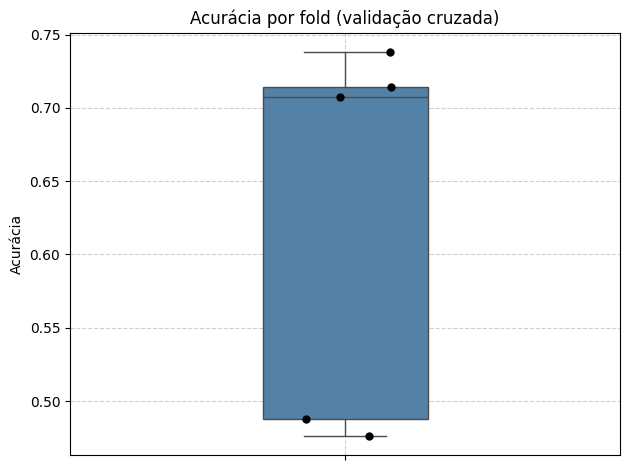


--- Grid Search ---
Melhores parâmetros: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2}
Melhor score na validação cruzada: 0.7468805704099821

--- Desempenho no Teste ---
Acurácia no conjunto de teste: 0.6428571428571429
Acurácia: 0.6428571428571429
Precisão: 0.5161290322580645
Recall (Sensibilidade): 1.0
F1-Score: 0.6808510638297872
AUC (ROC): 0.8329326923076923
Especificidade: 0.4230769230769231


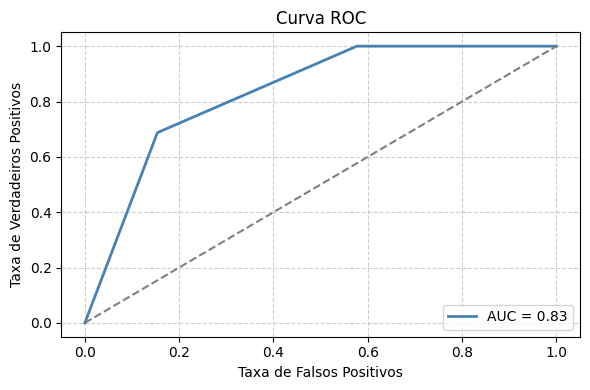

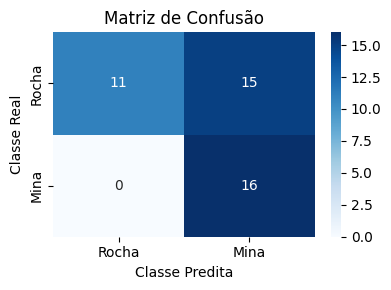

In [12]:
# Parte 1. Criação das features: PCA para redução de dimensionalidade
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

df = pd.read_csv("sonar_dataset.csv", header=None)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# codificar rótulos (M = 1, R = 0)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# aplicar PCA (95% da variância)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print("Número de componentes mantidas:", pca.n_components_)

# Parte 2. Modelo de ML: Árvore de decisão
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

# treinar modelo
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Parte 3. Avaliação de modelos: validação cruzada
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

scores = cross_val_score(clf, X_pca, y_encoded, cv=5)
print("\n--- Validação Cruzada ---")
print("Acurácias por fold:", scores)
print("Acurácia média (CV):", np.mean(scores))

# boxplot dos scores por fold
sns.boxplot(y=scores, color="steelblue", width=0.3)
sns.stripplot(y=scores, color="black", size=6, jitter=True)
plt.title("Acurácia por fold (validação cruzada)")
plt.ylabel("Acurácia")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Parte 4. Busca hiperparamétrica: GridSearch
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [2, 4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')

grid.fit(X_train, y_train)

print("\n--- Grid Search ---")
print("Melhores parâmetros:", grid.best_params_)
print("Melhor score na validação cruzada:", grid.best_score_)

# Parte 5. Pruning de Árvores de Decisão
best_tree = grid.best_estimator_
y_pred = best_tree.predict(X_test)

from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print("\n--- Desempenho no Teste ---")
print("Acurácia no conjunto de teste:", acc)

# Parte 6. Avaliação dos classificadores binários
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_score, recall_score, f1_score
)

# predições
y_prob = best_tree.predict_proba(X_test)[:, 1]
y_pred = best_tree.predict(X_test)

# métricas principais
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# sensibilidade e especificidade
tn, fp, fn, tp = cm.ravel()
sensibilidade = tp / (tp + fn)
especificidade = tn / (tn + fp)

print("Acurácia:", acc)
print("Precisão:", prec)
print("Recall (Sensibilidade):", rec)
print("F1-Score:", f1)
print("AUC (ROC):", auc)
print("Especificidade:", especificidade)

# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='steelblue', lw=2, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# matriz de confusão
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
            xticklabels=['Rocha', 'Mina'], 
            yticklabels=['Rocha', 'Mina'])
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()